# Auxiliary Samplers

Along with sampling the spatial and luminosity distributions, auxiliary properties and be sampled that both depend on and/or influence the luminosity as well each other. This allows you to build up arbitrailiy complex dependencies between parameters which can lead to diverse populations.


In [1]:

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="notebook", fscale=1, grid=False)

purple = "#B833FF"
yellow = "#F6EF5B"

import warnings

warnings.simplefilter("ignore")


import popsynth

popsynth.update_logging_level("INFO")

## Built in auxiliary samplers

There are several built in auxiliary samplers that allow you to quickly add on auxiliary parameters.


In [2]:
popsynth.list_available_auxiliary_samplers()

DeltaAuxSampler
LogNormalAuxSampler
Log10NormalAuxSampler
NormalAuxSampler
ParetoAuxSampler
PowerLawAuxSampler
BrokenPowerLawAuxSampler
TruncatedNormalAuxSampler
ViewingAngleSampler


We can add these on to the populations, but let's have a look at how to use them.

In [3]:
x = popsynth.NormalAuxSampler(name="aux_param", observed=True)

x.mu = 0
x.sigma = 1

# draws the observed values from normal distribution with std equal to tau
x.tau = 1

If value of x is observed (generates data), then we can set the width of the normal distribtuion from which the observed values are sampled from the latent values. Otherwise, only the latent values are stored. This applies to any of the built in auxiliary samplers. However, this can all be customized by adding our own:

## Creating a custom auxiliary sampler
Let's create two auxiliary samplers that sample values from normal distributions with some dependency on each other.

First, we specify the main population. This time, we will chose a SFR-like redshift distribution and a Schecter luminosity function


In [4]:
pop_gen = popsynth.populations.SchechterSFRPopulation(
    r0=100,a=0.0157, rise=1.0, decay=1.0, peak=1.0, Lmin=1e50, alpha=2.0
)

Suppose we have a property "demo" that we want to sample as well. For this property, we do not observe it directly. We will get to that. This means that our property latent and could influence other parameters but we can not measure it directly. If you are familiar with Bayesian hierarchical models, this concept may be more familiar to you. As an example, this could be the temperature of a star, which influences its spectrum. The spectrum creates an observable, but the tempreature is imply a random latent variable sampled from a distribution. 


We create an ```AuxiliarySampler``` child class, and define the *true_sampler* for the latent values:

In [5]:
class DemoSampler(popsynth.AuxiliarySampler):
    _auxiliary_sampler_name = "DemoSampler"

    mu = popsynth.auxiliary_sampler.AuxiliaryParameter(default=2)
    tau = popsynth.auxiliary_sampler.AuxiliaryParameter(default=1, vmin=0)

    def __init__(self):

        # pass up to the super class
        super(DemoSampler, self).__init__("demo", observed=False)

    def true_sampler(self, size):

        # sample the latent values for this property

        self._true_values = np.random.normal(self.mu, self.tau, size=size)

Now we instantiate it and then assign it our pop_gen object. Then we draw out survey

 INFO     |  registering auxilary sampler: demo 


 INFO     |  The volume integral is 4760.754853877658 


Drawing distances:   0%|          | 0/4693 [00:00<?, ?it/s]

 INFO     |  Expecting 4693 total objects 


 INFO     |  Sampling: demo 


 INFO     |  applying selection to fluxes 


 INFO     |  Detected 3223 distances 


 INFO     |  Detected 3223 objects out to a distance of 8.44 


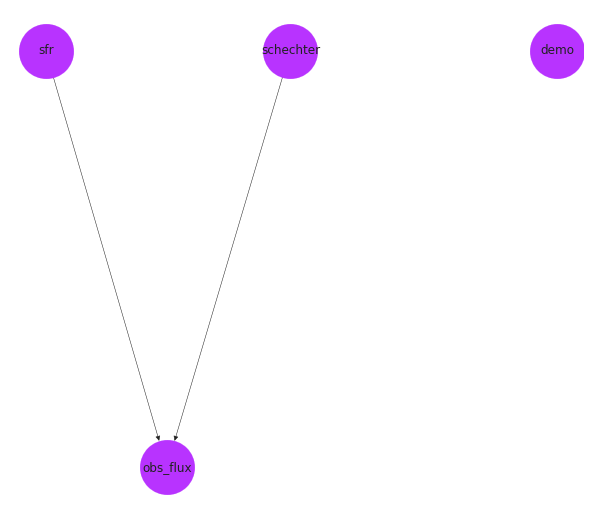

In [6]:
demo1 = DemoSampler()

pop_gen.add_observed_quantity(demo1)


flux_selector = popsynth.HardFluxSelection()
flux_selector.boundary = 1e-9

pop_gen.set_flux_selection(flux_selector)

population = pop_gen.draw_survey()



## plot it
options = {"node_color": purple, "node_size": 3000, "width": 0.5}
pos = nx.drawing.nx_agraph.graphviz_layout(population.graph, prog="dot")
nx.draw(population.graph, with_labels=True, pos=pos, **options)

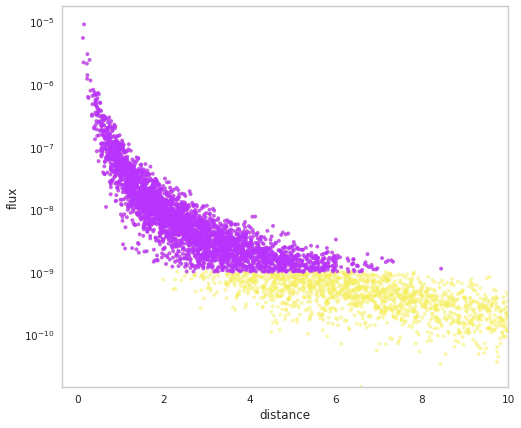

In [7]:
fig = population.display_fluxes(obs_color=purple, true_color=yellow, s=15)

We can see that the population has stored out demo auxiliary property.

In [8]:
all_demo = population.demo

selected_demo = population.demo.selected

We can also see that our demo sampler is now known which is important when creating populations from YAML files. This registering happens when we add the property ```_auxiliary_sampler_name = "DemoSampler" ``` which must be name of the class!

In [9]:
popsynth.list_available_auxiliary_samplers()

DeltaAuxSampler
LogNormalAuxSampler
Log10NormalAuxSampler
NormalAuxSampler
ParetoAuxSampler
PowerLawAuxSampler
BrokenPowerLawAuxSampler
TruncatedNormalAuxSampler
ViewingAngleSampler
DemoSampler


## Observed auxiliary properties and dependent parameters

Suppose now we want to simulate a property that is observed by an instrument but depends on latent parameters.

We will create a second demo sampler and tell it what the observational error is as well as how to read from a secondary sampler:

In [10]:
class DemoSampler2(popsynth.AuxiliarySampler):
    _auxiliary_sampler_name = "DemoSampler2"
    mu = popsynth.auxiliary_sampler.AuxiliaryParameter(default=2)
    tau = popsynth.auxiliary_sampler.AuxiliaryParameter(default=1, vmin=0)
    sigma = popsynth.auxiliary_sampler.AuxiliaryParameter(default=1, vmin=0)

    def __init__(
        self,
    ):

        # this time set observed=True
        super(DemoSampler2, self).__init__("demo2", observed=True, uses_distance=True)

    def true_sampler(self, size):

        # we access the secondary sampler dictionary. In this
        # case "demo". This itself is a sampler with
        # <>.true_values as a parameter
        secondary = self._secondary_samplers['demo']

        # now we sample the demo2 latent values and add on the dependence of "demo"

        tmp = np.random.normal(self.mu, self.tau, size=size)

        # for fun, we can substract the log of the distance as all
        # auxiliary samples know about their distances

        self._true_values = tmp + secondary.true_values - np.log10(1 + self._distance)

    def observation_sampler(self, size):

        # here we define the "observed" values, i.e., the latened values
        # with observational error

        self._obs_values = self._true_values + np.random.normal(
            0, self.sigma, size=size
        )

We recreate our base sampler:

In [11]:
pop_gen = popsynth.populations.SchechterSFRPopulation(
    r0=100, a=0.0157, rise=1.0, decay=1.0, peak=1.0, Lmin=1e50, alpha=2.0
)

Now, make a new *demo1*, but this time we do not have to attach it to the base sampler. Instead, we will assign it as a secondary sampler to *demo2* and **popsynth** is smart enough to search for it when it draws a survey.

In [12]:
demo1 = DemoSampler()


demo2 = DemoSampler2()

demo2.set_secondary_sampler(demo1)

# attach to the base sampler
pop_gen.add_observed_quantity(demo2)

 INFO     |  registering auxilary sampler: demo2 


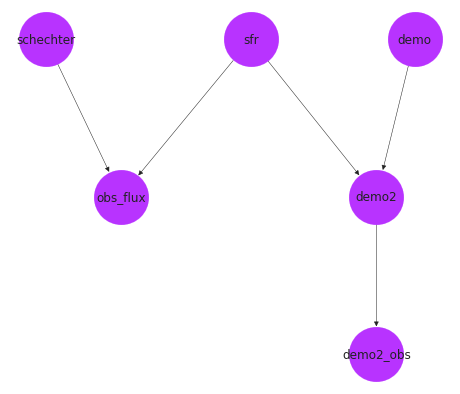

In [13]:
pos = nx.drawing.nx_agraph.graphviz_layout(pop_gen.graph, prog="dot")


fig, ax = plt.subplots()


nx.draw(pop_gen.graph, with_labels=True, pos=pos, ax=ax, **options)

In [14]:

flux_selector = popsynth.HardFluxSelection()
flux_selector.boundary = 1e-8

pop_gen.set_flux_selection(flux_selector)
population = pop_gen.draw_survey(flux_sigma=0.1)

 INFO     |  The volume integral is 4760.754853877658 


Drawing distances:   0%|          | 0/4693 [00:00<?, ?it/s]

 INFO     |  Expecting 4693 total objects 


 INFO     |  Sampling: demo2 


 INFO     |  demo2 is sampling its secondary quantities 


 INFO     |  Sampling: demo 


 INFO     |  applying selection to fluxes 


 INFO     |  Detected 1124 distances 


 INFO     |  Detected 1124 objects out to a distance of 3.18 


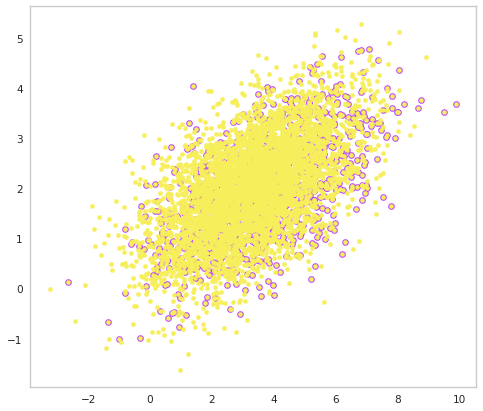

In [15]:
fig, ax = plt.subplots()

ax.scatter(population.demo2.selected, population.demo.selected, c=purple, s=40)

ax.scatter(population.demo2, population.demo, c=yellow, s=20)

## Derived Luminosity sampler

Sometimes, the luminosity does not come directly from a distribution. Rather, it is computed from other quantities. In these cases, we want to use the **DerivedLumAuxSampler** class.

This allows you to sample auxiliary parameters and compute a luminosity from those.

In [16]:
class DemoSampler3(popsynth.DerivedLumAuxSampler):
    _auxiliary_sampler_name = "DemoSampler3"
    mu = popsynth.auxiliary_sampler.AuxiliaryParameter(default=1)
    tau = popsynth.auxiliary_sampler.AuxiliaryParameter(default=1, vmin=0)

    def __init__(self, mu=2, tau=1.0, sigma=1):

        # this time set observed=True
        super(DemoSampler3, self).__init__("demo3", uses_distance=False)

    def true_sampler(self, size):

        # draw a random number
        tmp = np.random.normal(self.mu, self.tau, size=size)

        self._true_values = tmp

    def compute_luminosity(self):

        # compute the luminosity
        secondary = self._secondary_samplers["demo"]

        return (10 ** (self._true_values + 54)) + secondary.true_values

In [17]:
pop_gen = popsynth.populations.SchechterSFRPopulation(
    r0=100,a=0.0157, rise=1.0, decay=1.0, peak=1.0, Lmin=1e50, alpha=2.0
)

 INFO     |  registering derived luminosity sampler: demo3 


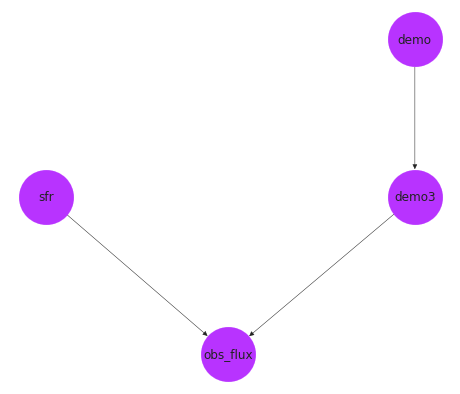

In [18]:
demo1 = DemoSampler()


demo3 = DemoSampler3()

demo3.set_secondary_sampler(demo1)

# attach to the base sampler
pop_gen.add_observed_quantity(demo3)


pos = nx.drawing.nx_agraph.graphviz_layout(pop_gen.graph, prog="dot")

fig, ax = plt.subplots()

nx.draw(pop_gen.graph, with_labels=True, pos=pos, **options, ax=ax)

In [19]:
flux_selector = popsynth.HardFluxSelection()
flux_selector.boundary = 1e-5
pop_gen.set_flux_selection(flux_selector)
population = pop_gen.draw_survey(flux_sigma=0.1)

 INFO     |  The volume integral is 4760.754853877658 


Drawing distances:   0%|          | 0/4693 [00:00<?, ?it/s]

 INFO     |  Expecting 4693 total objects 


 INFO     |  Sampling: demo3 


 INFO     |  demo3 is sampling its secondary quantities 


 INFO     |  Sampling: demo 


 INFO     |  Getting luminosity from derived sampler 


 INFO     |  applying selection to fluxes 


 INFO     |  Detected 3752 distances 


 INFO     |  Detected 3752 objects out to a distance of 9.99 


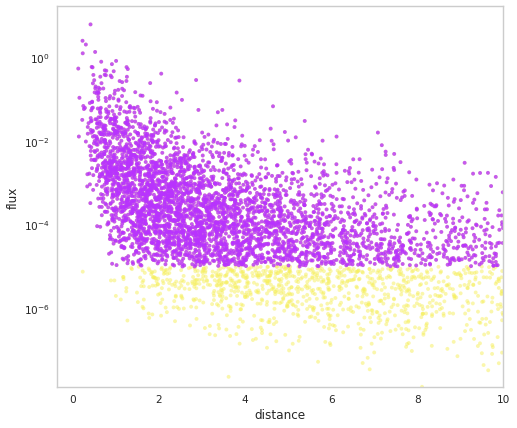

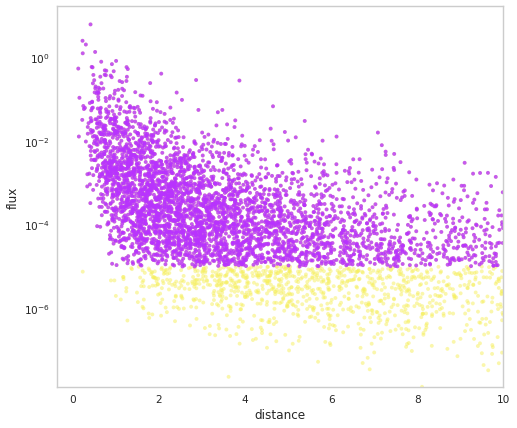

In [20]:
population.display_fluxes(obs_color=purple, true_color=yellow, s=15)